In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from influence_rate_from_llm import InfluenceRateManager
import logging
logging.disable('WARN')
pd.set_option('display.max_colwidth', None)

In [2]:
def get_influence_data(irm, pr_url, num_runs, prompt_text, gt_df):
    run_data = []
    for _ in range(num_runs):
        influence = irm.get_total_influence(pr_url, prompt_text)
        run_data.append(influence[['comment_id', 'issue_type', 'comment_text', 'influence_pred', 'explanation']])
    df = pd.concat(run_data, keys=range(num_runs), names=['run', 'index']).reset_index()
    df = df.merge(gt_df, on='comment_id', how='left').set_index(['run', 'index'])
    df['correct_pred'] = df.apply(lambda row: int(row['influence_pred'] == row['influence_gt']), axis=1)
    return df

def calculate_influence_statistics(df):
    num_runs = df.index.get_level_values('run').nunique()
    num_influential = df.groupby(level='run')['influence_pred'].sum()
    avg_influential = num_influential.mean()
    total_comments = df.groupby(level='run')['comment_id'].nunique().mean()
    return num_runs, num_influential, avg_influential, total_comments

def plot_line_graph(df):
    num_runs, num_influential, avg_influential, total_comments = calculate_influence_statistics(df)
    num_influential_gt = df.groupby(level='run')['influence_gt'].sum()
    plt.plot(range(num_runs), num_influential, marker='o', label='Predicted Comments')
    plt.axhline(y=avg_influential, color='r', linestyle='--', label='Predicted Average')
    plt.plot(num_influential_gt, color='g', label='GT Comments')
    plt.xlabel('Run Number')
    plt.ylabel('Number of Influential Comments')
    plt.title(f'Influential Comments vs Run Number (Total Comments: {total_comments})')
    plt.xticks(range(num_runs))
    plt.legend()
    plt.grid()
    plt.show()

def calculate_std_dev_df(df):
    grouped_data = df.groupby('comment_id')['influence_pred'].std()
    sorted_data = grouped_data.sort_values(ascending=False)
    return sorted_data

def plot_std_dev_graph(df):
    sorted_data = calculate_std_dev_df(df)
    plt.bar(range(len(sorted_data)), sorted_data)
    plt.xlabel('Comment ID (sorted by standard deviation)')
    plt.xticks(range(len(sorted_data)), labels=sorted_data.index, rotation=90)
    plt.ylabel('Standard Deviation')
    plt.title(f'Standard Deviation for Comment IDs for {df.index.get_level_values("run").nunique()} Runs')
    plt.show()
    return sorted_data

def plot_accuracy_graph(df):
    accuracy_df = df.groupby('comment_id')['correct_pred'].mean().reset_index()
    accuracy_df = accuracy_df.sort_values(by='correct_pred', ascending=False)
    plt.bar(range(len(accuracy_df)), accuracy_df['correct_pred']*100)
    plt.xlabel('Comment ID (sorted by prediction accuracy)')
    plt.xticks(range(len(accuracy_df)), labels=accuracy_df['comment_id'], rotation=90)
    plt.ylabel('Prediction Accuracy %')
    plt.title(f'Prediction Accuracy per Comment ID for {df.index.get_level_values("run").nunique()} Runs')
    plt.show()
    return accuracy_df

In [3]:
gt = pd.read_csv('influence_rate_gt_data.csv')
gt['comment_id'] = gt['comment_id'].astype(str)

In [4]:
prompt_text = """
i will provide you with two inputs based on a merged Github pull request:
1. a code review comment made on a specific file of that pull request.
2. the code diff of the same file that the comment was made on\n
your task is to determine whether the review comment has been resolved in the given code diff or not.
provide a step-by-step explanation for why you think the comment was resolved or not. 
if are confident that the comment has been resolved in the code diff, provide '1'. 
otherwise, provide '0'.
you must output your answer in the json format as follows: {"explanation": <your explanation>, "resolved": <1 or 0>}
"""

In [5]:
pr_url = 'https://github.amd.com/ATG/CVMLSDK/pull/2085'

num_runs = 1
irm = InfluenceRateManager()
df = get_influence_data(irm, pr_url, num_runs, prompt_text, gt)

Retrieved 6 comments from DB


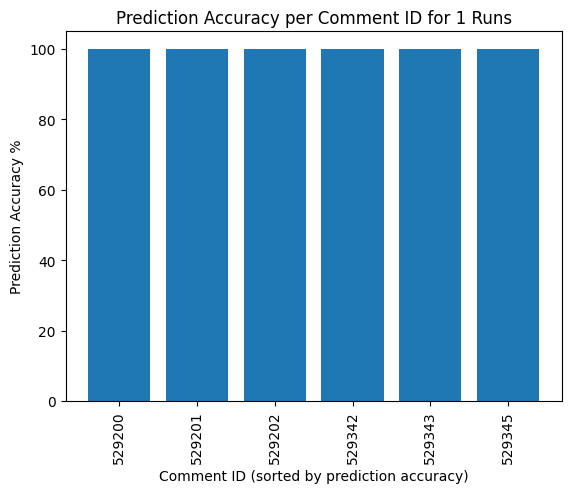

In [6]:
accuracy_df = plot_accuracy_graph(df)
least_accurate = accuracy_df[accuracy_df['correct_pred'] < 0.8]['comment_id']
least_accurate = df.loc[df['comment_id'].isin(least_accurate)]

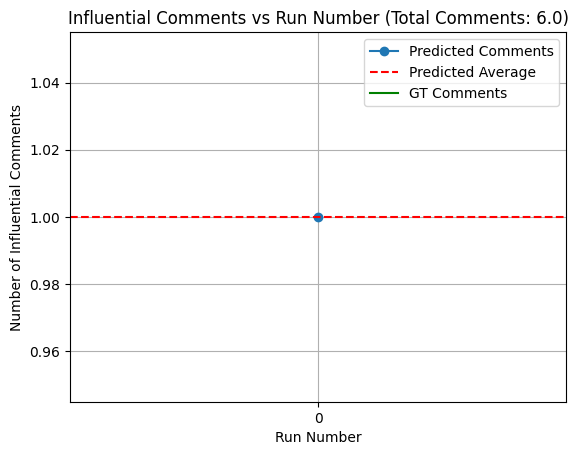

In [7]:
plot_line_graph(df)

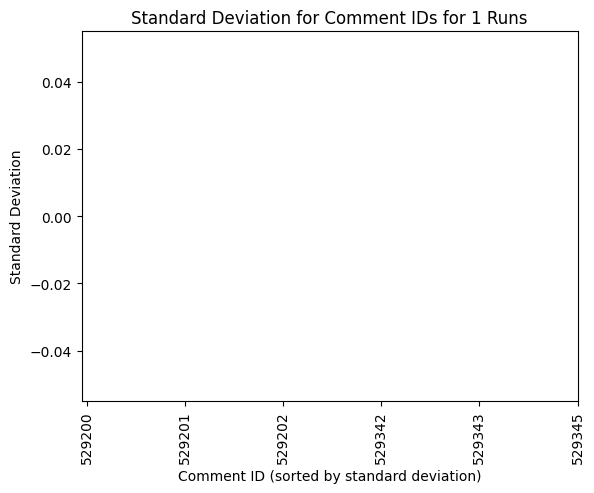

In [8]:
std_df = plot_std_dev_graph(df)
least_consistent = std_df[std_df > 0.5].index

In [9]:
# show the least accurate, consistent and wrong comments for further investigation
# worst = (least_accurate['comment_id'].isin(least_consistent)) & (least_accurate['correct_pred'] == 0)
# least_accurate.loc[worst,['explanation', 'comment_url']]